# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
OPTIMIZERS = ['sgd', 'RMSprop', 'Adagrad', 'Adam']
LEARNING_RATE = [1e-1, 1e-2, 1e-3]
EPOCHS = 12
BATCH_SIZE = 256
clipvalue=0.5

In [8]:
#得到不同的 optimizer 的函數
def get_Opt(opt_name, lr):
    if opt_name=='sgd':
        print('sgd')
        optimizer = keras.optimizers.SGD(lr=lr, clipvalue=clipvalue)
    elif opt_name=='RMSprop':
        print('RMSprop')
        optimizer = keras.optimizers.RMSprop(lr=lr, clipvalue=clipvalue)
    elif opt_name=='Adagrad':
        print('Adagrad')
        optimizer = keras.optimizers.Adagrad(lr=lr, clipvalue=clipvalue)
    elif opt_name=='Adam':
        print('Adam')
        optimizer = keras.optimizers.Adam(lr=lr, clipvalue=clipvalue)
    else:
        print('opt_name error')
        return None;
    return optimizer

In [9]:
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
results = {}
for lr in LEARNING_RATE:
    for opt in OPTIMIZERS:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f in %s" % (lr, opt))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = get_Opt(opt, lr)
        
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        exp_name_tag = "exp-lr-%s-%s" %(str(lr),opt)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with LR = 0.100000 in sgd
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________
sgd

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [===

50000/50000 [==============================] - 2s 38us/step - loss: 1.7479 - accuracy: 0.3665 - val_loss: 1.7172 - val_accuracy: 0.3787
Epoch 9/12
50000/50000 [==============================] - 2s 40us/step - loss: 1.7229 - accuracy: 0.3767 - val_loss: 1.7234 - val_accuracy: 0.3772
Epoch 10/12
50000/50000 [==============================] - 2s 38us/step - loss: 1.6986 - accuracy: 0.3851 - val_loss: 1.7565 - val_accuracy: 0.3660
Epoch 11/12
50000/50000 [==============================] - 2s 39us/step - loss: 1.6749 - accuracy: 0.3921 - val_loss: 1.7584 - val_accuracy: 0.3640
Epoch 12/12
50000/50000 [==============================] - 2s 38us/step - loss: 1.6642 - accuracy: 0.4012 - val_loss: 1.6612 - val_accuracy: 0.3997
Experiment with LR = 0.100000 in Adam
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
____________________

50000/50000 [==============================] - 2s 39us/step - loss: 1.9264 - accuracy: 0.2918 - val_loss: 1.9094 - val_accuracy: 0.2968
Epoch 6/12
50000/50000 [==============================] - 2s 39us/step - loss: 1.9054 - accuracy: 0.3010 - val_loss: 2.1376 - val_accuracy: 0.2762
Epoch 7/12
50000/50000 [==============================] - 2s 39us/step - loss: 1.8949 - accuracy: 0.3059 - val_loss: 2.0150 - val_accuracy: 0.2764
Epoch 8/12
50000/50000 [==============================] - 2s 38us/step - loss: 1.8796 - accuracy: 0.3152 - val_loss: 2.1300 - val_accuracy: 0.2546
Epoch 9/12
50000/50000 [==============================] - 2s 39us/step - loss: 1.8683 - accuracy: 0.3209 - val_loss: 1.9241 - val_accuracy: 0.3033
Epoch 10/12
50000/50000 [==============================] - 2s 41us/step - loss: 1.8583 - accuracy: 0.3265 - val_loss: 1.9516 - val_accuracy: 0.3005
Epoch 11/12
50000/50000 [==============================] - 2s 43us/step - loss: 1.8526 - accuracy: 0.3309 - val_loss: 1.8861 - v

50000/50000 [==============================] - 2s 37us/step - loss: 2.2128 - accuracy: 0.1756 - val_loss: 2.1871 - val_accuracy: 0.1905
Epoch 3/12
50000/50000 [==============================] - 2s 36us/step - loss: 2.1655 - accuracy: 0.2014 - val_loss: 2.1428 - val_accuracy: 0.2174
Epoch 4/12
50000/50000 [==============================] - 2s 36us/step - loss: 2.1228 - accuracy: 0.2295 - val_loss: 2.1029 - val_accuracy: 0.2382
Epoch 5/12
50000/50000 [==============================] - 2s 36us/step - loss: 2.0858 - accuracy: 0.2470 - val_loss: 2.0699 - val_accuracy: 0.2536
Epoch 6/12
50000/50000 [==============================] - 2s 37us/step - loss: 2.0538 - accuracy: 0.2609 - val_loss: 2.0395 - val_accuracy: 0.2717
Epoch 7/12
50000/50000 [==============================] - 2s 36us/step - loss: 2.0264 - accuracy: 0.2736 - val_loss: 2.0143 - val_accuracy: 0.2868
Epoch 8/12
50000/50000 [==============================] - 2s 37us/step - loss: 2.0026 - accuracy: 0.2870 - val_loss: 1.9927 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 2s 43us/step - loss: 1.9250 - accuracy: 0.3065 - val_loss: 1.7630 - val_accuracy: 0.3693
Epoch 2/12
50000/50000 [==============================] - 2s 41us/step - loss: 1.7261 - accuracy: 0.3837 - val_loss: 1.6648 - val_accuracy: 0.4027
Epoch 3/12
50000/50000 [==============================] - 2s 42us/step - loss: 1.6438 - accuracy: 0.4167 - val_loss: 1.5939 - val_accuracy: 0.4303
Epoch 4/12
50000/50000 [==============================] - 2s 41us/step - loss: 1.5806 - accuracy: 0.4368 - val_loss: 1.6469 - val_accuracy: 0.4219
Epoch 5/12
50000/50000 [==============================] - 2s 42us/step - loss: 1.5491 - accuracy: 0.4473 - val_loss: 1.5340 - val_accuracy: 0.4531
Epoch 6/12
50000/50000 [==============================] - 2s 41us/step - loss: 1.4981 - accuracy: 0.4670 - val_loss: 1.5202 - val_accuracy: 0.4542
Epoch 7/12
50000/50000 [==============================] - 2s 42us/st

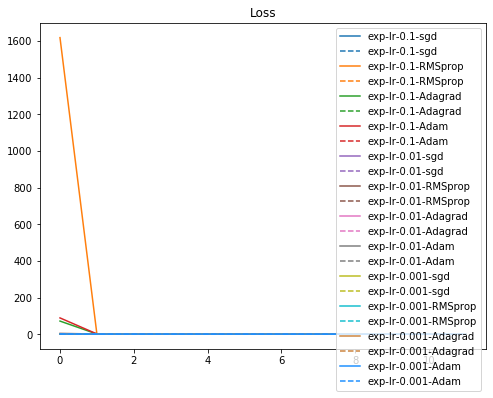

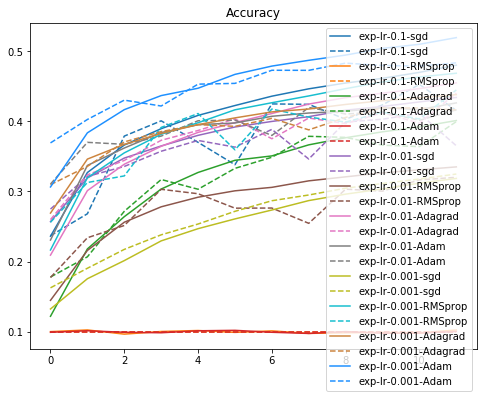

In [13]:
import matplotlib.pyplot as plt

"""
將實驗結果繪出
"""
color_bar = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
             "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
            "peru", "dodgerblue"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()